In [1]:
# --- Install Libraries ---
!pip install transformers datasets peft torchinfo timm -q
!pip install nvidia-ml-py3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# --- Imports ---
import os
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
from torchinfo import summary
from peft import LoraConfig, get_peft_model
from timm.layers import LayerNorm2d

In [3]:
# --- Setup Tokenizer and Base Model ---
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("distilgpt2")
model.config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
# --- Dynamic Tanh ---
class DynamicTanh(nn.Module):
    def __init__(self, normalized_shape, channels_last, alpha_init_value=0.5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.alpha_init_value = alpha_init_value
        self.channels_last = channels_last

        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        if self.channels_last:
            x = x * self.weight + self.bias
        else:
            x = x * self.weight[:, None, None] + self.bias[:, None, None]
        return x

    def extra_repr(self):
        return f"normalized_shape={self.normalized_shape}, alpha_init_value={self.alpha_init_value}, channels_last={self.channels_last}"


def convert_ln_to_dyt(module):
    module_output = module
    if isinstance(module, nn.LayerNorm):
        module_output = DynamicTanh(module.normalized_shape, not isinstance(module, LayerNorm2d))
    for name, child in module.named_children():
        module_output.add_module(name, convert_ln_to_dyt(child))
    del module
    return module_output

In [5]:
model = convert_ln_to_dyt(model)

In [6]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): DynamicTanh(normalized_shape=(768,), alpha_init_value=0.5, channels_last=True)
  )
  (lm_head): Linear(in_features=768, out_features=5

In [7]:
# --- Summary ---
from torchinfo import summary

summary(model, input_size=(1, 128), dtypes=[torch.int64])

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    [1, 12, 128, 64]          --
├─GPT2Model: 1-1                                   [1, 12, 128, 64]          --
│    └─Embedding: 2-1                              [1, 128, 768]             38,597,376
│    └─Embedding: 2-2                              [1, 128, 768]             786,432
│    └─Dropout: 2-3                                [1, 128, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-2                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-3                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-4                         [1, 128, 768]             7,087,874
│    │    └─GPT2Block: 3-5                         [1, 128, 768]          

In [8]:
# --- PEFT Config (LoRA Injection) ---
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["c_attn","fc_in", "fc_out"],  # DistilGPT2 uses c_attn in attention, # c_attn + MLP layers
    task_type="CAUSAL_LM",
)

In [9]:
peft_model = get_peft_model(model, peft_config)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [10]:
print("Trainable parameters after PEFT injection:")
peft_model.print_trainable_parameters()

Trainable parameters after PEFT injection:
trainable params: 147,456 || all params: 82,060,045 || trainable%: 0.1797


In [11]:
# --- Model Summary ---
summary(peft_model, input_size=(1, 128), dtypes=[torch.int64])

Layer (type:depth-idx)                                       Output Shape              Param #
PeftModelForCausalLM                                         [1, 12, 128, 64]          --
├─LoraModel: 1-1                                             [1, 12, 128, 64]          --
│    └─GPT2LMHeadModel: 2-1                                  --                        --
│    │    └─GPT2Model: 3-1                                   [1, 12, 128, 64]          82,060,045
│    │    └─Linear: 3-2                                      [1, 128, 50257]           (38,597,376)
Total params: 120,657,421
Trainable params: 147,456
Non-trainable params: 120,509,965
Total mult-adds (Units.GIGABYTES): 81.71
Input size (MB): 0.00
Forward/backward pass size (MB): 119.93
Params size (MB): 482.63
Estimated Total Size (MB): 602.56

In [15]:
import json

# --- Load the uploaded ShareGPT JSON ---
with open("/content/ShareGPT_V3_unfiltered_cleaned_split.json", 'r') as f:
    data = json.load(f)

print("Loaded", len(data), "conversations.")


Loaded 94145 conversations.


In [18]:
print(len(data))
print(list(data[0].keys()))
for i in range(5):
    print(data[i])

94145
['id', 'conversations']
{'id': 'QWJhYvA_0', 'conversations': [{'from': 'human', 'value': "Summarize the main ideas of Jeff Walker's Product Launch Formula into bullet points as it pertains to a growth marketing agency implementing these strategies and tactics for their clients..."}, {'from': 'gpt', 'value': "Here are the main ideas of Jeff Walker's Product Launch Formula that can be applied by a growth marketing agency for their clients:\n\n1. Identify the target audience and their needs: Understand the ideal customer for the product or service, and create a messaging that resonates with them.\n2. Pre-launch: Build anticipation and excitement for the launch by creating buzz, gathering testimonials and case studies, and using social media to create awareness.\n3. Launch: Use a well-crafted launch sequence to maximize sales and conversions. This can include offering bonuses, creating scarcity, and using a deadline to create urgency.\n4. Post-launch: Follow up with customers, gather

In [19]:
for i in range(5):
    print(f"\nConversation {i+1}:")
    for turn in data[i]['conversations']:
        print(f"[{turn['from'].upper()}]: {turn['value']}")
    print("="*80)



Conversation 1:
[HUMAN]: Summarize the main ideas of Jeff Walker's Product Launch Formula into bullet points as it pertains to a growth marketing agency implementing these strategies and tactics for their clients...
[GPT]: Here are the main ideas of Jeff Walker's Product Launch Formula that can be applied by a growth marketing agency for their clients:

1. Identify the target audience and their needs: Understand the ideal customer for the product or service, and create a messaging that resonates with them.
2. Pre-launch: Build anticipation and excitement for the launch by creating buzz, gathering testimonials and case studies, and using social media to create awareness.
3. Launch: Use a well-crafted launch sequence to maximize sales and conversions. This can include offering bonuses, creating scarcity, and using a deadline to create urgency.
4. Post-launch: Follow up with customers, gather feedback, and continue to provide value to keep them engaged and loyal.
5. Create a product suit

In [20]:
# def preprocess(batch):
#     prompts = []
#     responses = []

#     for example in batch:
#         conversation = example.get("conversations", [])
#         user_message = ""
#         assistant_message = ""

#         for turn in conversation:
#             if turn.get("from") == "human" and not user_message:
#                 user_message = turn.get("value", "")
#             elif turn.get("from") == "gpt" and not assistant_message:
#                 assistant_message = turn.get("value", "")

#         if user_message and assistant_message:
#             prompts.append(user_message.strip())
#             responses.append(assistant_message.strip())

#     full_texts = [p + "\n\n" + r for p, r in zip(prompts, responses)]

#     tokenized_batch = tokenizer(
#         full_texts,
#         truncation=True,
#         padding="max_length",
#         max_length=512,
#     )

#     return tokenized_batch

# # --- Preprocess the loaded JSON
# tokenized_data = preprocess(data)
# print(f"Preprocessed {len(tokenized_data['input_ids'])} examples.")


Preprocessed 92731 examples.


In [21]:
def preprocess_single(example):
    conversation = example.get("conversations", [])
    user_message = ""
    assistant_message = ""

    for turn in conversation:
        if turn.get("from") == "human" and not user_message:
            user_message = turn.get("value", "")
        elif turn.get("from") == "gpt" and not assistant_message:
            assistant_message = turn.get("value", "")

    if user_message and assistant_message:
        prompt = user_message.strip()
        response = assistant_message.strip()
        full_text = prompt + "\n\n" + response

        tokenized = tokenizer(
            full_text,
            truncation=True,
            padding="max_length",
            max_length=512,
        )
        return tokenized
    else:
        return None

# Now, process the whole dataset properly
processed_data = []

for example in data:
    tokenized = preprocess_single(example)
    if tokenized:
        processed_data.append(tokenized)

# Convert to lists
input_ids = [d['input_ids'] for d in processed_data]
attention_mask = [d['attention_mask'] for d in processed_data]

print(f"Preprocessed {len(input_ids)} examples.")


Preprocessed 92731 examples.


In [22]:
# --- Train/Test Split manually
from sklearn.model_selection import train_test_split
import torch

input_ids = torch.tensor(tokenized_data['input_ids'])
attention_mask = torch.tensor(tokenized_data['attention_mask'])

train_inputs, val_inputs, train_masks, val_masks = train_test_split(
    input_ids, attention_mask, test_size=0.05, random_state=42
)

# Wrap into torch.utils.data.Dataset
class GPT2Dataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask):
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.input_ids[idx],  # Important: labels = inputs for LM
        }

train_dataset = GPT2Dataset(train_inputs, train_masks)
eval_dataset = GPT2Dataset(val_inputs, val_masks)


In [23]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=1000,  # Save every 1000 steps
    save_total_limit=2,  # Keep last 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    # warmup_steps=500,
    lr_scheduler_type="cosine",  # Smooth LR decay
    optim="adamw_torch",
    weight_decay=0.01,
    learning_rate=5e-5, # SMALL LR for GPT-2 finetuning
    fp16=True,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",  # disable WandB
)

In [25]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)


base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_B.default.weight


In [ ]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


In [ ]:
import math

final_loss = trainer.evaluate()["eval_loss"]
final_perplexity = math.exp(final_loss)
print(f"Final Evaluation Perplexity: {final_perplexity}")


Final Evaluation Perplexity: 4068.6659252066584


In [ ]:
!pip install matplotlib -q
import matplotlib.pyplot as plt
import numpy as np

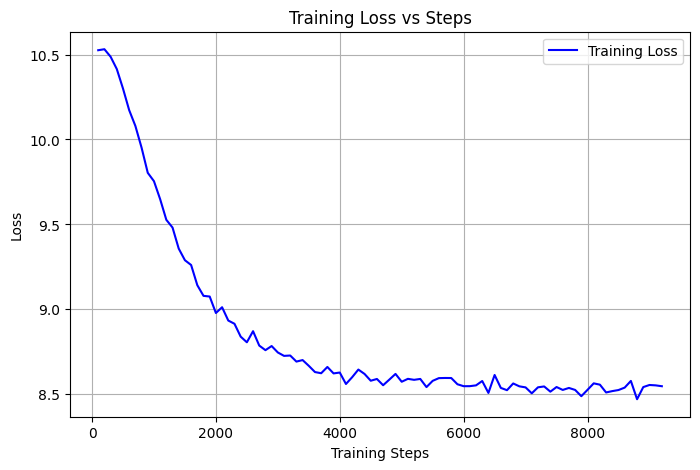

In [ ]:
# --- Training Loss Plot
train_loss_steps = []
train_losses = []

for record in trainer.state.log_history:
    if 'loss' in record and 'learning_rate' in record:  # skip eval loss entries
        train_loss_steps.append(record['step'])
        train_losses.append(record['loss'])

plt.figure(figsize=(8,5))
plt.plot(train_loss_steps, train_losses, label='Training Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()

# --- Validation Loss Plot
eval_loss_steps = []
eval_losses = []

for record in trainer.state.log_history:
    if 'eval_loss' in record:
        eval_loss_steps.append(record['step'])
        eval_losses.append(record['eval_loss'])

plt.figure(figsize=(8,5))
plt.plot(eval_loss_steps, eval_losses, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()

# --- Training and Validation Together
plt.figure(figsize=(8,5))
plt.plot(train_loss_steps, train_losses, label='Training Loss', color='blue')
plt.plot(eval_loss_steps, eval_losses, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Steps')
plt.grid(True)
plt.legend()
plt.show()


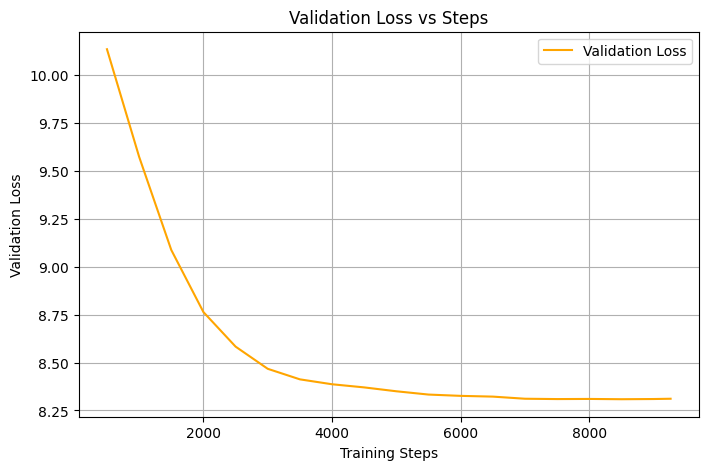

In [ ]:
# Validation Perplexity Progression
perplexities = [math.exp(l) for l in eval_losses]

plt.figure(figsize=(8,5))
plt.plot(eval_loss_steps, perplexities, label='Validation Perplexity', color='green')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity Progression')
plt.grid(True)
plt.legend()
plt.show()


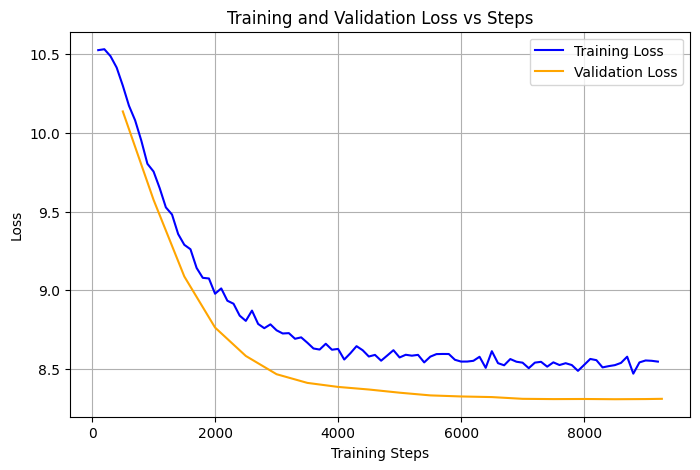

In [ ]:
# Assuming you know total params and trainable params:
total_params = 82060181  # Example for DistilGPT2
trainable_params = 147456  # LoRA trainable parameters

frozen_params = total_params - trainable_params

labels = ['Trainable (LoRA)', 'Frozen']
sizes = [trainable_params, frozen_params]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Parameter Distribution After LoRA Injection')
plt.axis('equal')  # Equal aspect ratio
plt.show()


In [ ]:
trainer.save_model("./distilgpt2_sharegpt_peft")  # or whatever your current name
tokenizer.save_pretrained("./distilgpt2_sharegpt_peft")


In [ ]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./distilgpt2_sharegpt_peft")

# Load base model first
base_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Load PEFT LoRA weights
model = PeftModel.from_pretrained(base_model, "./distilgpt2_sharegpt_peft")

# Set padding tokens correctly
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

print("Model and tokenizer successfully loaded!")


In [ ]:
def generate_response(prompt, model, tokenizer, max_new_tokens=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded

# Example:
prompt = "Explain how rainbows are formed."
response = generate_response(prompt, model, tokenizer)
print(response)
